In [ ]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.autograd import Variable
import numpy as np
from torch import optim
from matplotlib import pyplot as plt

## Revising previous RNN model

In [ ]:
# alpha = 0.2 # Extracted from tha parameter tables in the paper
alpha = 0.5
class rectifiedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(rectifiedRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.fc_ih = nn.Linear(input_size, hidden_size)
        self.fc_hh = nn.Linear(hidden_size, hidden_size)
        self.fc_ho = nn.Linear(hidden_size, output_size)
        
        # D matrix
        diag = torch.ones(hidden_size)
        # we assume that almost 20% of the weights are inhibitory, so....
        n_inhibit = hidden_size // 5 + 1
        diag[0:n_inhibit - 1] = -1
        self.D = torch.diag(diag)
        
    def segregate_weights(self, W_hh):
        for i in range(self.hidden_size):
            W_hh[i, i] = 0.0
            W_hh_corrected = torch.matmul(torch.abs(W_hh), self.D)
        W_hh = 0.5 * (W_hh + W_hh_corrected)
        
        return W_hh
        
    def forward(self, input_data, hidden):
        new_weight = self.segregate_weights(self.fc_hh.weight)
        self.fc_hh.weight = torch.nn.Parameter(new_weight)
        hidden_next = torch.tanh((1 - alpha) * hidden + alpha * (self.fc_ih(input_data) + self.fc_hh(torch.tanh(hidden))))
        output = torch.tanh(self.fc_ho(hidden_next))
        hidden = hidden_next
        
        return (output, hidden)

## Task one: Preceptual decision making

# Dataset for fixed period

First, we need to create a dataset for this task.

This dataset will contain a series of fixed duration pulses in two different levels. Some noise will also be added to them to make them more *real*.

In [ ]:
dc_1 = 6 + (2 * torch.rand(1) - 1)
dc_2 = 8 + (2 * torch.rand(1) - 1)

DC_values = torch.tensor([dc_1, dc_2])

noise_1 = 0.5 * torch.randn((10000, 1))
noise_2 = 0.5 * torch.randn((10000, 1))

number_of_tests = 100
stimulus_time = 0.8 * (10000 // number_of_tests)
total_time = 10000 // number_of_tests
# for each trial, a signal starts from 0, until 10% of its total time
# then the stimulus begins, then finishes at about 90% of the total time
# then once again it bocomes silent for the remaining 10%
s1 = torch.zeros((10000, 1))
s2 = torch.zeros((10000, 1))
target = torch.zeros((10000, 2))

for i in range(10000):
    if (i % total_time) <= (0.1 * total_time) :
        s1[i, 0] = noise_1[i, 0]
        s2[i, 0] = noise_2[i, 0]
        picked = False
    elif (0.1 * total_time) <= i % total_time <= (0.9 * total_time) :
        if picked is False:
            pick_index = torch.randint(0, 2, (1, 1))
            picked = True
            dc_1 = 6 + (2 * torch.rand(1) - 1)
            dc_2 = 8 + (2 * torch.rand(1) - 1)
            DC_values = torch.tensor([dc_1, dc_2])

        
        if (pick_index == 0) :
            s1[i, 0] = noise_1[i, 0] + DC_values[0]
            s2[i, 0] = noise_2[i, 0] + DC_values[1]
            
            target[i, 0] = 0
            target[i, 1] = 1
        else :
            s1[i, 0] = noise_1[i, 0] + DC_values[1]
            s2[i, 0] = noise_2[i, 0] + DC_values[0]
            
            target[i, 0] = 1
            target[i, 1] = 0
    
    else:
        s1[i, 0] = noise_1[i, 0]
        s2[i, 0] = noise_2[i, 0]
        picked = False
        

Text(0.5, 1.0, 'dataset sample for fixed period')

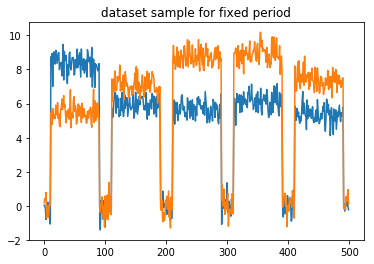

In [6]:
plt.plot(s1[5 * total_time:10 * total_time].numpy())
plt.plot( s2[5 * total_time:10 * total_time].numpy())
plt.title('dataset sample for fixed period')

## Parameters and optimizers

In [ ]:
lr = 0.001
number_of_epochs = 3
net = rectifiedRNN(2, 20, 2)
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr)

In [ ]:
runing_loss = 0.0
loss_list = list()
window = 50
batch_size = total_time

for epoch in range(number_of_epochs):
    for i in range(50):
      hidden = torch.zeros(20)
      for t in range(total_time):
        optimizer.zero_grad()
        (output, hidden) = net(torch.tensor([s1[i * total_time + t, 0], s2[i * total_time + t, 0]]), hidden)
        loss = criterion(output, target[i * total_time + t, :])
        hidden.detach_()
        loss.backward()      
        optimizer.step()
        loss_list.append(loss.data)
        runing_loss = 0.0

In [ ]:
window = 40
mean_loss = list()
for i in range(len(loss_list) // window):
  temp = 0
  for j in range(window):
    temp += loss_list[i * window + j]
  temp /= window
  mean_loss.append(temp)
  
plt.plot(mean_loss)

In [ ]:
# runing_loss = 0.0
# loss_list = list()
window = 50
sample = 35
batch_size = total_time
output_list = list()
hidden = torch.zeros(20)
for k in range(5):
  hidden = torch.zeros(20)
  for i in range(total_time):
    stim1 = s1[(sample + k) * total_time + i, 0]
    stim2 = s2[(sample + k) * total_time + i, 0]
    d = target[(sample + k) * total_time + i, :]
    (out, hidden) = net(torch.tensor([stim1, stim2]), hidden)
    output_list.append(out.data.numpy())
  

In [ ]:
plt.plot(output_list)
plt.title('output for test data')

In [ ]:
plt.plot(target[sample * total_time: (sample + 5) * total_time, :].numpy())
plt.title('correct output for test data')

In [ ]:
plt.plot(s1[sample * total_time : (sample + 5) * total_time, :].numpy())
plt.plot(s2[sample * total_time : (sample + 5) * total_time, :].numpy())
plt.title('input test data')

In [ ]:
layers = [x.data for x in net.parameters()]

In [ ]:
plt.imshow(layers[2].numpy())
plt.title('network weight matrix')

In [ ]:
# runing_loss = 0.0
# loss_list = list()
window = 50
sample = 20
batch_size = total_time
output_list = list()
hidden = torch.zeros(20)
for k in range(40):
  hidden = torch.zeros(20)
  temp = torch.zeros(2)
  for i in range(total_time):
    stim1 = s1[(sample + k) * total_time + i, 0]
    stim2 = s2[(sample + k) * total_time + i, 0]
    d = target[(sample + k) * total_time + i, :]
    (out, hidden) = net(torch.tensor([stim1, stim2]), hidden)
    
    if i >= total_time * 0.1 and i < total_time * 0.9:
      temp += out
    
  output_list.append((temp / (total_time * 0.8)).data.numpy())
  
for i in range(len(output_list)):
  if output_list[i][0] > output_list[i][1]:
    output_list[i][0] = 1
    output_list[i][1] = 0
  else:
    output_list[i][0] = 0
    output_list[i][1] = 1

## Preceptual decision making dataset for variable duration

In [ ]:
dc_1 = 6 + (2 * torch.rand(1) - 1)
dc_2 = 8 + (2 * torch.rand(1) - 1)

DC_values = torch.tensor([dc_1, dc_2])

noise_1 = 0.5 * torch.randn((10000, 1))
noise_2 = 0.5 * torch.randn((10000, 1))

number_of_tests = 100
stimulus_time = 0.8 * (10000 // number_of_tests)
total_time = 10000 // number_of_tests
# for each trial, a signal starts from 0, until 10% of its total time
# then the stimulus begins, then finishes at about 90% of the total time
# then once again it bocomes silent for the remaining 10%
s1 = torch.zeros((10000, 1))
s2 = torch.zeros((10000, 1))
target = torch.zeros((10000, 2))
period = 30 + torch.randint(0, 71, (1, 1))

for i in range(10000):
    if (i % total_time) <= (0.1 * total_time) :
        s1[i, 0] = noise_1[i, 0]
        s2[i, 0] = noise_2[i, 0]
        picked = False
    elif (0.1 * total_time) <= i % total_time <= period + 1 :
        if picked is False:
            period = 30 + torch.randint(0, 71, (1, 1))
            pick_index = torch.randint(0, 2, (1, 1))
            picked = True
            dc_1 = 6 + (2 * torch.rand(1) - 1)
            dc_2 = 8 + (2 * torch.rand(1) - 1)
            DC_values = torch.tensor([dc_1, dc_2])

        
        if (pick_index == 0) :
            s1[i, 0] = noise_1[i, 0] + DC_values[0]
            s2[i, 0] = noise_2[i, 0] + DC_values[1]
            
            target[i, 0] = 0
            target[i, 1] = 1
        else :
            s1[i, 0] = noise_1[i, 0] + DC_values[1]
            s2[i, 0] = noise_2[i, 0] + DC_values[0]
            
            target[i, 0] = 1
            target[i, 1] = 0
    
    else:
        s1[i, 0] = noise_1[i, 0]
        s2[i, 0] = noise_2[i, 0]
        picked = False
        

Text(0.5, 1.0, 'Variable duration dataset sample')

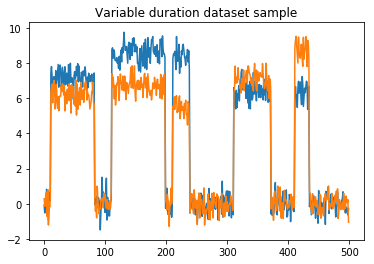

In [9]:
plt.plot(s1[5 * total_time:10 * total_time].numpy())
plt.plot( s2[5 * total_time:10 * total_time].numpy())
plt.title('Variable duration dataset sample')

In [ ]:
lr = 0.001
number_of_epochs = 5
net = rectifiedRNN(2, 20, 2)
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr)

In [ ]:
runing_loss = 0.0
loss_list = list()
window = 50
batch_size = total_time

for epoch in range(number_of_epochs):
    for i in range(50):
      hidden = torch.zeros(20)
      for t in range(total_time):
        optimizer.zero_grad()

#       for b in range(batch_size):
#         net.reinit_hidden()
        (output, hidden) = net(torch.tensor([s1[i * total_time + t, 0], s2[i * total_time + t, 0]]), hidden)
        loss = criterion(output, target[i * total_time + t, :])
#         runing_loss += loss.data
        hidden.detach_()
        loss.backward()      
        optimizer.step()
#         if i % window == 0 :
        loss_list.append(loss.data)
        runing_loss = 0.0
      
#       print(i)

In [ ]:
# runing_loss = 0.0
# loss_list = list()
window = 50
sample = 35
batch_size = total_time
output_list = list()
hidden = torch.zeros(20)
for k in range(5):
  hidden = torch.zeros(20)
  for i in range(total_time):
    stim1 = s1[(sample + k) * total_time + i, 0]
    stim2 = s2[(sample + k) * total_time + i, 0]
    d = target[(sample + k) * total_time + i, :]
    (out, hidden) = net(torch.tensor([stim1, stim2]), hidden)
    output_list.append(out.data.numpy())
  

In [ ]:
plt.plot(output_list)
plt.title('output for test data')

In [ ]:
plt.plot(target[sample * total_time: (sample + 5) * total_time, :].numpy())
plt.title('correct output for test data')

In [ ]:
plt.plot(s1[sample * total_time : (sample + 5) * total_time, :].numpy())
plt.plot(s2[sample * total_time : (sample + 5) * total_time, :].numpy())
plt.title('input test data')

In [ ]:
layers = [x.data for x in net.parameters()]
plt.imshow(layers[2].numpy())
plt.title('network weight matrix')

## Working memory Task

In [ ]:
total_time = 100
silence_1 = 25
stim_1 = 50
silence_2 = 75
number_of_trials = 100

WM_dataset = torch.zeros(total_time * number_of_trials, 1)
WM_target = torch.zeros(total_time * number_of_trials, 2)

abs_noise = torch.abs(0.3 * torch.randn(total_time * number_of_trials, 1))
noise = 0.3 * torch.randn(total_time * number_of_trials, 1)

dc_1 = 4 + (8 * torch.rand(1) - 4)
dc_2 = 12 + (8 * torch.rand(1) - 4)

DC_values = torch.tensor([dc_1, dc_2])
index = torch.randint(0, 2, (1, 1))


for i in range(number_of_trials):
    dc_1 = 4 + (8 * torch.rand(1) - 4)
    dc_2 = 12 + (8 * torch.rand(1) - 4)

    DC_values = torch.tensor([dc_1, dc_2])
    for t in range(total_time):
        if t < silence_1 :
            pick_index = True
            WM_dataset[i * total_time + t, 0] = abs_noise[i * total_time + t, 0]
        elif t >= silence_1 and t < stim_1 :
            if pick_index is True :
                index = torch.randint(0, 2, (1, 1))
                pick_index = False
            WM_dataset[i * total_time + t, 0] = DC_values[index] + noise[i * total_time + t, 0]
        elif t >= stim_1 and t < silence_2 :
            WM_dataset[i * total_time + t, 0] = abs_noise[i * total_time + t, 0]
        else :
            if index == 0:
                WM_dataset[i * total_time + t, 0] = noise[i * total_time + t, 0] + DC_values[1]
                WM_target[i * total_time + t, :] = torch.tensor([0, 1])
            else :
                WM_dataset[i * total_time + t, 0] = noise[i * total_time + t, 0] + DC_values[0]
                WM_target[i * total_time + t, :] = torch.tensor([1, 0])
        
            
            

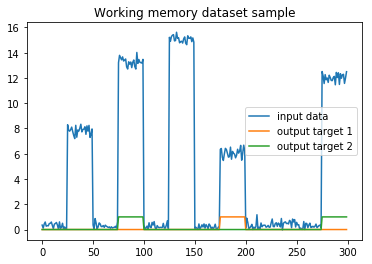

In [29]:
plt.plot(WM_dataset[9 * total_time : 12 * total_time].numpy())
plt.plot(WM_target[9 * total_time : 12 * total_time].numpy())
plt.title('Working memory dataset sample')
plt.legend(['input data', 'output target 1', 'output target 2'])

In [ ]:
number_of_hidden = 10
net = rectifiedRNN(1, number_of_hidden, 2)
lr = 0.001
optimizer = optim.Adam(net.parameters(), lr)
criterion = nn.MSELoss()
number_of_epochs = 5

In [ ]:
loss_list = list()
batch_size = 25

optimizer.zero_grad()

for epoch in range(number_of_epochs):
  for trial in range(number_of_trials):
    hidden = torch.zeros(number_of_hidden)
    for t in range(100):
      (output, hidden) = net(WM_dataset[trial * 100 + t, :], hidden)
      loss = criterion(output, WM_target[trial * 100 + t, :])
      hidden.detach_()
      loss.backward()
      
      if(t % batch_size == 0):
        optimizer.step()
        optimizer.zero_grad()
        loss_list.append(loss)
      

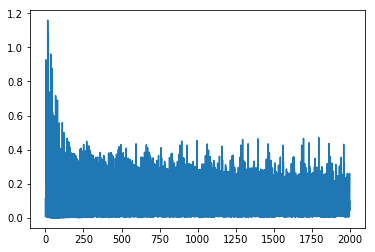

In [8]:
plt.plot(loss_list)

In [ ]:
# runing_loss = 0.0
# loss_list = list()
window = 50
sample = 20
batch_size = total_time
output_list = list()
hidden = torch.zeros(number_of_hidden)
for k in range(80):
  hidden = torch.zeros(number_of_hidden)
  for i in range(total_time):
    stim = WM_dataset[(sample + k) * total_time + i, :]
    d = WM_target[(sample + k) * total_time + i, :]
    (out, hidden) = net(stim, hidden)
    output_list.append(out.data.numpy())
  

In [ ]:
# runing_loss = 0.0
# loss_list = list()
window = 50
sample = 20
batch_size = total_time
target_list = list()
hidden = torch.zeros(number_of_hidden)
for k in range(80):
#   hidden = torch.zeros(number_of_hidden)
  for i in range(total_time):
#     stim = WM_dataset[(sample + k) * total_time + i, :]
    d = WM_target[(sample + k) * total_time + i, :]
#     (out, hidden) = net(stim, hidden)
#     output_list.append(out.data.numpy())
    target_list.append(d.numpy())
# plt.plot(target_list)

In [26]:
output_compare = torch.zeros(80, 2)

for i in range(80):
  if output_list[i * 100 + 83][0] > output_list[i * 100 + 83][1] :
    output_compare[i, :] = torch.tensor([1, 0])
  else :
    output_compare[i, :] = torch.tensor([0, 1])
    
# plt.plot(output_compare.numpy())
true = 0

for i in range(80):
  if output_compare[i, :].numpy().all() == target_list[i * 100 + 83][:].all():
    true += 1
    
print('accuracy is :', int(true / 80 * 100), ' percent')

accuracy is : 100  percent


Text(0.5, 1.0, 'network weight matrix')

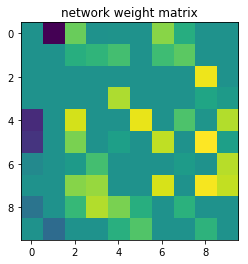

In [28]:
layers = [x.data for x in net.parameters()]
plt.imshow(layers[2].numpy())
plt.title('network weight matrix')

## Sequence execution task

In [ ]:
# we need 9 dot inputs and 8 sequence inputs
# so every slice of dataset is 17 units
# every trial has 5 moves, a rest, a set, and three decisions
# we conduct 100 trials, so we need a 100 * 5 * 17 tensor
# for target values, we observe x-y coordinates, these are extracted from the sequence number by hand
# the target tensor is a 100 * 5 * 2 tensor

number_of_trials = 100

SEQ_dataset = torch.zeros(100, 5, 17)
SEQ_target = torch.zeros(100, 5, 2)

# these are the target x-y values for every sequence

seq_x = torch.zeros(8, 5)
seq_x[0, :] = torch.tensor([0, 0, 1, 0, -1])
seq_x[1, :] = torch.tensor([0, 0, -1, 0, 1])
seq_x[2, :] = torch.tensor([0, 0, -1, 0, 1])
seq_x[3, :] = torch.tensor([0, 0, 1, 0, -1])
seq_x[4, :] = torch.tensor([0, 0, 1, 0, 1])
seq_x[5, :] = torch.tensor([0, 0, -1, 0, -1])
seq_x[6, :] = torch.tensor([0, 0, -1, 0, -1])
seq_x[7, :] = torch.tensor([0, 0, 1, 0, 1])

seq_y = torch.zeros(8, 5)
seq_y[0, :] = torch.tensor([0, 0, 0, 1, 1])
seq_y[1, :] = torch.tensor([0, 0, 0, 1, 1])
seq_y[2, :] = torch.tensor([0, 0, 0, -1, -1])
seq_y[3, :] = torch.tensor([0, 0, 0, -1, -1])
seq_y[4, :] = torch.tensor([0, 0, 0, 1, 1])
seq_y[5, :] = torch.tensor([0, 0, 0, 1, 1])
seq_y[6, :] = torch.tensor([0, 0, 0, -1, -1])
seq_y[7, :] = torch.tensor([0, 0, 0, -1, -1])

# each sequence corresponds with a dot sequence in input
dot_sequence = torch.zeros(8, 5, 9)

def to_one_hot(input_number):
    one_hot_out = torch.zeros(9)
    one_hot_out[input_number - 1] = 1
    
    return one_hot_out
    
target = torch.zeros(8, 5, 2)

# sequence 1: quiet, 5, (5, 6, 4), (6, 2, 8), (2, 1, 3)
dot_sequence[0, 0, :] = torch.zeros(9)
dot_sequence[0, 1, :] = to_one_hot(5)
dot_sequence[0, 2, :] = to_one_hot(5) + to_one_hot(6) + to_one_hot(4)
dot_sequence[0, 3, :] = to_one_hot(6) + to_one_hot(2) + to_one_hot(8)
dot_sequence[0, 4, :] = to_one_hot(2) + to_one_hot(1) + to_one_hot(3)

# sequence 2: quiet, 5, (5, 4, 6), (4, 2, 8), (2, 3, 1)
dot_sequence[1, 0, :] = torch.zeros(9)
dot_sequence[1, 1, :] = to_one_hot(5)
dot_sequence[1, 2, :] = to_one_hot(5) + to_one_hot(4) + to_one_hot(6)
dot_sequence[1, 3, :] = to_one_hot(4) + to_one_hot(2) + to_one_hot(8)
dot_sequence[1, 4, :] = to_one_hot(2) + to_one_hot(3) + to_one_hot(1)

# sequence 3: quiet, 5, (5, 4, 6), (4, 8, 2), (8, 9, 7)
dot_sequence[2, 0, :] = torch.zeros(9)
dot_sequence[2, 1, :] = to_one_hot(5)
dot_sequence[2, 2, :] = to_one_hot(5) + to_one_hot(4) + to_one_hot(6)
dot_sequence[2, 3, :] = to_one_hot(4) + to_one_hot(2) + to_one_hot(8)
dot_sequence[2, 4, :] = to_one_hot(8) + to_one_hot(9) + to_one_hot(7)

# sequence 4: quiet, 5, (5, 6, 4), (6, 8, 2), (8, 7, 9)
dot_sequence[3, 0, :] = torch.zeros(9)
dot_sequence[3, 1, :] = to_one_hot(5)
dot_sequence[3, 2, :] = to_one_hot(5) + to_one_hot(6) + to_one_hot(4)
dot_sequence[3, 3, :] = to_one_hot(6) + to_one_hot(2) + to_one_hot(8)
dot_sequence[3, 4, :] = to_one_hot(8) + to_one_hot(7) + to_one_hot(9)

# sequence 5: quiet, 5, (5, 6, 4), (6, 2, 8), (2, 3, 1)
dot_sequence[4, 0, :] = torch.zeros(9)
dot_sequence[4, 1, :] = to_one_hot(5)
dot_sequence[4, 2, :] = to_one_hot(5) + to_one_hot(6) + to_one_hot(4)
dot_sequence[4, 3, :] = to_one_hot(6) + to_one_hot(2) + to_one_hot(8)
dot_sequence[4, 4, :] = to_one_hot(2) + to_one_hot(3) + to_one_hot(1)

# sequence 6: quiet, 5, (5, 4, 6), (4, 2, 8), (2, 1, 3)
dot_sequence[5, 0, :] = torch.zeros(9)
dot_sequence[5, 1, :] = to_one_hot(5)
dot_sequence[5, 2, :] = to_one_hot(5) + to_one_hot(4) + to_one_hot(6)
dot_sequence[5, 3, :] = to_one_hot(4) + to_one_hot(2) + to_one_hot(8)
dot_sequence[5, 4, :] = to_one_hot(2) + to_one_hot(1) + to_one_hot(3)

# sequence 7: quiet, 5, (5, 4, 6), (4, 8, 2), (8, 7, 9)
dot_sequence[6, 0, :] = torch.zeros(9)
dot_sequence[6, 1, :] = to_one_hot(5)
dot_sequence[6, 2, :] = to_one_hot(5) + to_one_hot(4) + to_one_hot(6)
dot_sequence[6, 3, :] = to_one_hot(4) + to_one_hot(8) + to_one_hot(2)
dot_sequence[6, 4, :] = to_one_hot(8) + to_one_hot(7) + to_one_hot(9)

# sequence 8: quiet, 5, (5, 6, 4), (6, 8, 2), (8, 9, 7)
dot_sequence[7, 0, :] = torch.zeros(9)
dot_sequence[7, 1, :] = to_one_hot(5)
dot_sequence[7, 2, :] = to_one_hot(5) + to_one_hot(6) + to_one_hot(4)
dot_sequence[7, 3, :] = to_one_hot(6) + to_one_hot(8) + to_one_hot(2)
dot_sequence[7, 4, :] = to_one_hot(8) + to_one_hot(9) + to_one_hot(7)

seq_exe = torch.randint(0, 8, (100, 1))

def to_one_hot_seq(input_num):
    one_hot_seq = torch.zeros(8)
    one_hot_seq[input_num] = 1
    
    return one_hot_seq

for i in range(100):
    for j in range(5):
        SEQ_dataset[i, j, 9:17] = to_one_hot_seq(seq_exe[i, 0])

for trial in range(number_of_trials):
    number = seq_exe[trial, 0]
    SEQ_dataset[trial, :, 0:9] = dot_sequence[number, :, :]
    SEQ_target[trial, :, 0] = seq_x[number, :]
    SEQ_target[trial, :, 1] = seq_y[number, :]

Text(0.5, 1.0, 'input sample for Sequence execution')

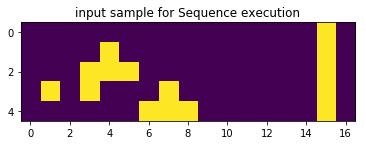

In [ ]:
plt.imshow(SEQ_dataset[1, :, :])
plt.title('input sample for Sequence execution')

In [ ]:
number_of_hidden = 20
lr = 0.01
net = rectifiedRNN(17, number_of_hidden, 2)
number_of_epochs = 15
optimizer = optim.Adam(net.parameters(), lr)
criterion = nn.MSELoss()

In [ ]:
loss_list = list()

for epoch in range(number_of_epochs):
  for trial in range(number_of_trials):
    hidden = torch.zeros(number_of_hidden)
    for move in range(5):
      optimizer.zero_grad()
      for t in range(10):
        output, hidden = net(SEQ_dataset[trial, move, :], hidden)
        loss = criterion(output, SEQ_target[trial, move, :])
        hidden.detach_()
        loss.backward()
      optimizer.step()
      loss_list.append(loss.data)
#     print('trial : ', trial)

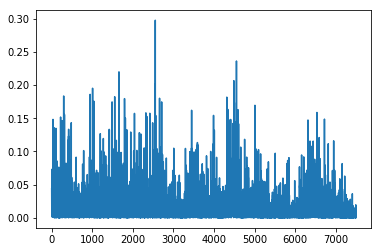

In [ ]:
plt.plot(loss_list)

In [ ]:
# loss_list = list()
output_list_x = list()
output_list_y = list()

# for epoch in range(number_of_epochs):
for trial in range(number_of_trials):
  hidden = torch.zeros(number_of_hidden)
  for move in range(5):
#       optimizer.zero_grad()
#       for t in range(10):
    output, hidden = net(SEQ_dataset[trial, move, :], hidden)
#         loss = criterion(output, SEQ_target[trial, move, :])
    hidden.detach_()
    output_list_x.append(output[0].data.numpy())
    output_list_y.append(output[1].data.numpy())
#         loss.backward()
#       optimizer.step()
#       loss_list.append(loss.data)
#     print('trial : ', trial)

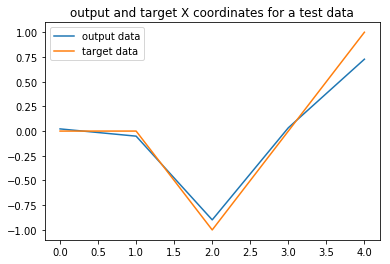

In [ ]:
plt.plot(output_list_x[9 * 5: 10 * 5])
plt.plot(SEQ_target[9, :, 0].numpy())
plt.title('output and target X coordinates for a test data')
plt.legend(['output data', 'target data'])

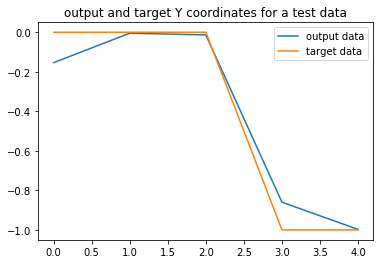

In [ ]:
plt.plot(output_list_y[9 * 5: 10 * 5])
plt.plot(SEQ_target[9, :, 1].numpy())
plt.title('output and target Y coordinates for a test data')
plt.legend(['output data', 'target data'])

Text(0.5, 1.0, 'network weight matrix')

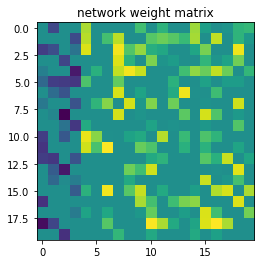

In [ ]:
layers = [x.data for x in net.parameters()]
plt.imshow(layers[2].numpy())
plt.title('network weight matrix')